In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, RMSprop

from lvi.components import DeterministicTensor, StochasticTensor, StochasticNetwork, FF_BNN
from lvi.optimizers import SGLD, pSGLD

In [8]:
df = pd.read_csv('real_estate.csv')
x = df.iloc[:, 0:6].to_numpy()
y = df.iloc[:, -1].to_numpy()
N = y.shape[0]

X, Y = torch.FloatTensor(x), torch.FloatTensor(y).unsqueeze(-1)
X.shape, Y.shape, N  # size: (data_batch_size, input/output_size)

(torch.Size([414, 6]), torch.Size([414, 1]), 414)

In [3]:
y.std()

13.590044806293161

In [4]:
model_arch_args = dict(
    num_inputs=X.shape[-1],
    num_outputs=Y.shape[-1],
    num_layers=0,
    hidden_sizes=[],
    activation_func=nn.Tanh, #nn.ReLU,
    chain_length=5000,
    stochastic_biases=False,
    output_distribution="normal",
    output_dist_const_params=dict(scale=1.0),
)

sgld_model_args = dict(
    group_by_layers=False,
    use_random_groups=False,
    use_permuted_groups=False,
    max_groups=None,
    dropout_prob=None,
    **model_arch_args,
)

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sgld_model = FF_BNN(**sgld_model_args)
sgld_model.initialize_optimizer(
    update_determ=True, 
    update_stoch=True, 
    lr=1e-10, #1e-5, 
    sgd=True, 
    sgld=False, 
    psgld=False,
)

In [6]:
import pickle
pickle.dump(sgld_model_args, open("./lr_sgld_model_params.pickle", "wb"))

In [9]:
num_epochs = 50000
for i in range(num_epochs):
    loss = sgld_model.training_step(
        batch=(X,Y),
        N=N,
        deterministic_weights=True,
        vi_batch_size=None,
    )

    if (i+1) % 10**math.floor(math.log10(i+1)) == 0:  # True when i+1 \in {1, 2, ..., 10, 20, ..., 100, 200, ..., 1000, 2000, ...}
        print("Iter {} / {}, Loss: {}".format(i+1, num_epochs, loss)) 

Iter 1 / 50000, Loss: 335859.625
Iter 2 / 50000, Loss: 234792.734375
Iter 3 / 50000, Loss: 173157.78125
Iter 4 / 50000, Loss: 134738.859375
Iter 5 / 50000, Loss: 110070.8515625
Iter 6 / 50000, Loss: 93620.84375
Iter 7 / 50000, Loss: 82147.890625
Iter 8 / 50000, Loss: 73747.1640625
Iter 9 / 50000, Loss: 67293.5234375
Iter 10 / 50000, Loss: 62117.30859375
Iter 20 / 50000, Loss: 36260.6875
Iter 30 / 50000, Loss: 27046.443359375
Iter 40 / 50000, Loss: 23537.2109375
Iter 50 / 50000, Loss: 22198.74609375
Iter 60 / 50000, Loss: 21687.33984375
Iter 70 / 50000, Loss: 21491.06640625
Iter 80 / 50000, Loss: 21414.869140625
Iter 90 / 50000, Loss: 21384.443359375
Iter 100 / 50000, Loss: 21371.4609375
Iter 200 / 50000, Loss: 21343.638671875
Iter 300 / 50000, Loss: 21324.591796875
Iter 400 / 50000, Loss: 21307.47265625
Iter 500 / 50000, Loss: 21292.072265625
Iter 600 / 50000, Loss: 21278.201171875
Iter 700 / 50000, Loss: 21265.677734375
Iter 800 / 50000, Loss: 21254.361328125
Iter 900 / 50000, Loss: 2

In [10]:
torch.save(sgld_model.state_dict(), "./lr_sgld_model_map.pt")

In [11]:
import pickle
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

lvi_model_params = pickle.load(open("./lr_sgld_model_params.pickle", "rb"))
lvi_model_params["group_by_layers"] = False
lvi_model_params["use_random_groups"] = False
lvi_model_params["use_permuted_groups"] = True
lvi_model_params["max_groups"] = 6
lvi_model_params["dropout_prob"] = 0.3
lvi_model_params["chain_length"] = 100000
lvi_model_params["output_distribution"] = "normal"
lvi_model_params["output_dist_const_params"] = dict(scale=1.0)

sgld_model = FF_BNN(**pickle.load(open("./lr_sgld_model_params.pickle", "rb")))
sgld_model.load_state_dict(torch.load("./lr_sgld_model_map.pt"))

lvi_model_params["init_values"] = {k:v.theta_actual.data for k,v in sgld_model.tensor_dict.items()}
del sgld_model

lvi_model = FF_BNN(**lvi_model_params)

lvi_model.initialize_optimizer(
    update_determ=False, 
    update_stoch=True, 
    lr=1e-3, 
    sgd=False, 
    sgld=False, 
    psgld=True,
)

In [13]:
dev = torch.device('cpu')
#dev = torch.device('cuda:0')

X, Y = X.to(dev), Y.to(dev)
#sgld_model = sgld_model.to(dev)
lvi_model = lvi_model.to(dev)
#for n, t in sgld_model.tensor_dict.items():
for n, t in lvi_model.tensor_dict.items():
    if isinstance(t, StochasticTensor):
        t.prior_dist.loc = t.prior_dist.loc.to(dev)
        t.prior_dist.scale = t.prior_dist.scale.to(dev)

In [14]:
# print("Before initialization: {}".format(sgld_model.num_samples_per_group))
# sgld_model.init_chains()
# print("After initialization: {}".format(sgld_model.num_samples_per_group))
print("Before initialization: {}".format(lvi_model.num_samples_per_group))
lvi_model.init_chains()
print("After initialization: {}".format(lvi_model.num_samples_per_group))

Before initialization: tensor([0, 0, 0, 0, 0, 0])
After initialization: tensor([1, 1, 1, 1, 1, 1])


In [15]:
def plot_pred_intervals(model, num_pred_samples, title, path):
    with torch.no_grad():
        Y_hat, sample_dict = model.sample_pred(
            X=X_range,
            deterministic=False,  #False,
            vi_batch_size=num_pred_samples,  #None,
            for_training=False,  #False,
        )

    sorted_Y_hat, _ = torch.sort(Y_hat.squeeze(-1), dim=0)  # size: (pred_batch_dim, observation_idx)

    med_Y_hat = sorted_Y_hat[round(num_pred_samples * 0.5), ...]
    #lower_ci_Y_hat = sorted_Y_hat[0, ...]
    #upper_ci_Y_hat = sorted_Y_hat[-1, ...]
    lower_ci_Y_hat = sorted_Y_hat[round(num_pred_samples * 0.025), ...]
    upper_ci_Y_hat = sorted_Y_hat[round(num_pred_samples * 0.975), ...]

    fig, ax = plt.subplots()
    ax.scatter(x,y,s=2, color="black")
    ax.plot(x_range, med_Y_hat.cpu().numpy())
    ax.fill_between(x_range, lower_ci_Y_hat.cpu().numpy(), upper_ci_Y_hat.cpu().numpy(), color='b', alpha=.2)
    ax.set_title(title)
    plt.show()
    if path is not None:
        fig.savefig(path, dpi=300, bbox_inches="tight")

In [16]:
from datetime import datetime

num_epochs = 150000
for i in range(num_epochs):
       
    if i < 100:
        loss = lvi_model.training_step(
            batch=(X,Y),
            N=N,
            deterministic_weights=True,  # First few iterations perform SGLD
            vi_batch_size=None,
        )
    else:
        loss = lvi_model.training_step(
            batch=(X,Y),
            N=N,
            deterministic_weights=False,  
            vi_batch_size=4,  
        )

#    if ((i+1) % 10000 == 0) or (i+1 == 1000) or (i+1 == 100) or (i == 0):
#         plot_pred_intervals(
#             model=lvi_model, 
#             num_pred_samples=lvi_model.chain_length // 10, 
#             title="LVI-D (grouped by: 10 random groups) - Iteration {}".format(i+1),
#             path=None, # "./lvi_d_random10_model_iter_{}.png".format(i+1),  # if None, will not save image
#         )
    
    if (i+1) % 10**math.floor(math.log10(i+1)) == 0:  # True when i+1 \in {1, 2, ..., 10, 20, ..., 100, 200, ..., 1000, 2000, ...}
        print("[{}] Iter {} / {}, Loss: {}".format(datetime.now(), i+1, num_epochs, loss))

/home/alexjb/source/sgld_experiments/lvi/optimizers.py:89: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  square_avg.mul_(alpha).addcmul_(1-alpha, d_p, d_p)


[2021-03-05 10:32:03.273818] Iter 1 / 150000, Loss: 123333.6875
[2021-03-05 10:32:03.276093] Iter 2 / 150000, Loss: 3287928.75
[2021-03-05 10:32:03.279094] Iter 3 / 150000, Loss: 444668.9375
[2021-03-05 10:32:03.281997] Iter 4 / 150000, Loss: 211015.390625
[2021-03-05 10:32:03.284092] Iter 5 / 150000, Loss: 176986.734375
[2021-03-05 10:32:03.285915] Iter 6 / 150000, Loss: 164220.9375
[2021-03-05 10:32:03.287763] Iter 7 / 150000, Loss: 155637.015625
[2021-03-05 10:32:03.289566] Iter 8 / 150000, Loss: 149243.53125
[2021-03-05 10:32:03.291379] Iter 9 / 150000, Loss: 144471.53125
[2021-03-05 10:32:03.293163] Iter 10 / 150000, Loss: 140792.390625
[2021-03-05 10:32:03.308882] Iter 20 / 150000, Loss: 129492.09375
[2021-03-05 10:32:03.324529] Iter 30 / 150000, Loss: 126969.7734375
[2021-03-05 10:32:03.340177] Iter 40 / 150000, Loss: 125227.03125
[2021-03-05 10:32:03.355866] Iter 50 / 150000, Loss: 123859.34375
[2021-03-05 10:32:03.371494] Iter 60 / 150000, Loss: 122794.875
[2021-03-05 10:32:03

KeyboardInterrupt: 

In [17]:
lvi_model.use_dropout, lvi_model.num_samples_per_group

(True, tensor([20129, 20076, 20182, 20223, 20062, 20099]))

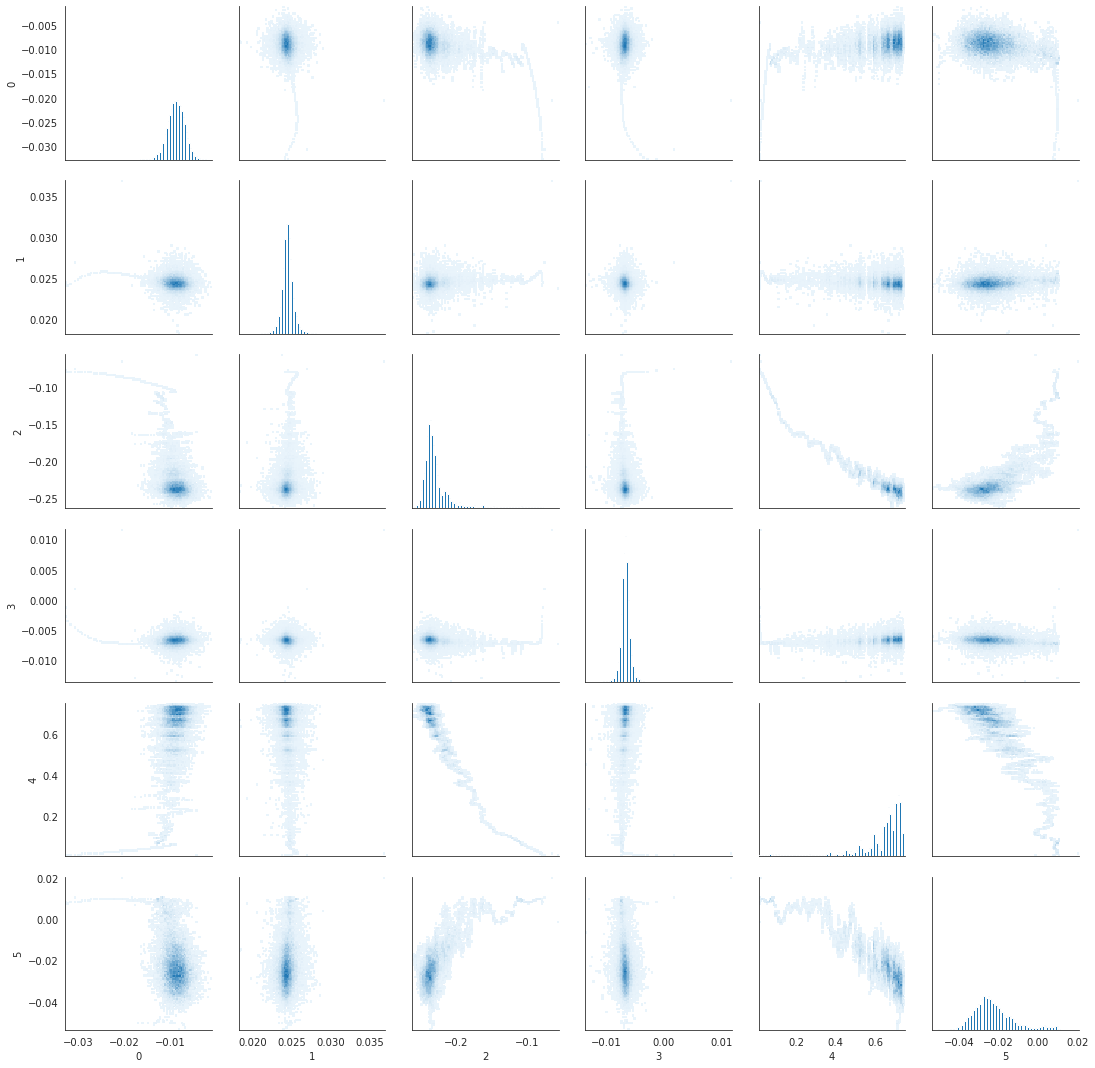

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_style("white")

#to_plot = sgld_model.tensor_dict.W_2.theta_chains.view(sgld_model.chain_length, -1).cpu().detach().numpy()
#to_plot = lvi_model.tensor_dict.W_2.theta_chains.view(lvi_model.chain_length, -1).cpu().detach().numpy()
to_plot = lvi_model.get_chains()["W_0"].squeeze().cpu().detach().numpy()

g = sns.PairGrid(pd.DataFrame(to_plot))
g.map_diag(plt.hist, bins=100)

def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)

g.map_offdiag(pairgrid_heatmap, bins=100)